# Lesson 04: Classification Performance ROCs

- evaluating and comparing trained models is of extreme importance when deciding in favor/against
  + model architectures
  + hyperparameter sets
  
- evaluating performance or quality of prediction is performed with a myriad of tests, figure-of-merits and even statistical hypothesis testing
- in the following, the rather popular "Receiver Operating Characteristic" curve (spoken ROC curve)
- the ROC was invented in WWII by radar engineers when seeking to detect enemy vessels and comparing different devices/techniques


## preface
- two main ingredients to ROC:

    + TPR = True Positive Rate
    + FPR = False Positive Rate
    

![from Wikipedia, ROC article](https://raw.githubusercontent.com/deeplearning540/lesson04/main/images/Screenshot_2021-02-24-Wikipedia-ROC.png)

- $TPR = \frac{TP}{TP+FN}$ also known as `recall`, always within $[0,1]$
- $FPR = \frac{FP}{FP+TN}$ also known as `fall-out`, always within $[0,1]$

## Data

For the following, I will rely (again) on the Palmer penguin dataset obtained from [this repo](https://github.com/allisonhorst/palmerpenguins). To quote the repo:

> Data were collected and made available by [Dr. Kristen Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php)
> and the [Palmer Station, Antarctica LTER](https://pal.lternet.edu/), a member of the [Long Term Ecological Research Network](https://lternet.edu/).


In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv")
#let's remove the rows with NaN values
df = df[ df.bill_length_mm.notnull() ]
#convert species column to 
df[["species_"]] = df[["species"]].astype("category")


In [3]:
print(df.shape)
print((df.species_.cat.codes < 1).shape)

#create binary column
df["is_adelie"] = (df.species_.cat.codes < 1).astype(np.int8)

print(df.head())


(342, 9)
(342,)
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  year species_  is_adelie  
0       3750.0    male  2007   Adelie          1  
1       3800.0  female  2007   Adelie          1  
2       3250.0  female  2007   Adelie          1  
4       3450.0  female  2007   Adelie          1  
5       3650.0    male  2007   Adelie          1  


In [4]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
print(f'seaborn version: {sns.__version__}')

seaborn version: 0.10.1


In [5]:
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.model_selection import train_test_split

kmeans = knn(n_neighbors=5)

In [6]:
#this time we train the knn algorithm, i.e. an unsupervised method is used in a supervised fashion
#prepare the data
X = np.stack((df.bill_length_mm, df.flipper_length_mm), axis=-1)
y = df.is_adelie

print(X.shape)
print(y.shape)


(342, 2)
(342,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .15,
                                                    random_state = 20210303)

print(X_train.shape)
print(y_train.shape)


print(X_test.shape)
print(y_test.shape)



(290, 2)
(290,)
(52, 2)
(52,)


In [8]:
kmeans = kmeans.fit(X_train, y_train)


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_hat = kmeans.predict(X_test)

cm = confusion_matrix( y_test, y_test_hat )

print(cm)


[[26  1]
 [ 3 22]]


1


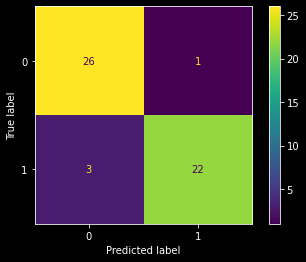

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(int(True))

# Starting to ROC

- let's take 4 samples of different size from our test set (as if we would conduct 4 experiments)


In [11]:
n_experiments = 4

X_test_exp = np.split(X_test[:32,...],n_experiments,axis=0)
y_test_exp = np.split(y_test.values[:32,...],n_experiments,axis=0)

print(X_test_exp[0].shape)
print(y_test_exp[0].shape)
y_test_exp

(8, 2)
(8,)


[array([1, 1, 1, 0, 0, 1, 1, 1], dtype=int8),
 array([0, 0, 0, 0, 1, 1, 1, 1], dtype=int8),
 array([0, 0, 1, 1, 0, 1, 0, 0], dtype=int8),
 array([1, 1, 1, 0, 0, 1, 1, 0], dtype=int8)]

In [12]:
y_test_hat = kmeans.predict(X_test)
y_test_hat_exp = np.split(y_test_hat[:32,...],n_experiments,axis=0)



In [13]:
#let's compute tpr and fpr for each
from sklearn.metrics import recall_score as tpr

def fpr(y_true, y_pred):
    """ compute the false positive rate using the confusion_matrix"""
    cm = confusion_matrix(y_true, y_pred)
    assert cm.shape == (2,2), f"{y_true.shape, y_pred.shape} => {cm,cm.shape}"
    cond_negative = cm[:,1].sum()
    value = cm[0,1] / cond_negative
    return value

tpr_ = []
fpr_ = []

for i in range(len(y_test_exp)):

    tpr_.append(tpr(y_test_exp[i], y_test_hat_exp[i]))
    fpr_.append(fpr(y_test_exp[i], y_test_hat_exp[i]))

print(tpr_)
print(fpr_)

[0.8333333333333334, 1.0, 1.0, 1.0]
[0.0, 0.2, 0.0, 0.0]


(0.0, 1.0)

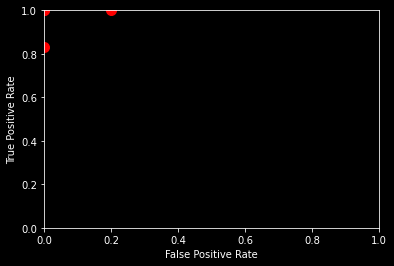

In [14]:
f, ax = plt.subplots(1)

ax.plot(fpr_, tpr_, 'ro', markersize=10)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim(0,1)
ax.set_ylim(0,1)


# But how to get from single entries to a full curve?

- in our case, we can employ the positive class prediction probabilities
- for KNN, this is given by the amount of N(true label)/N in the neighborhood around a query point

In [15]:
kmeans.predict_proba(X_test[:10])


array([[0. , 1. ],
       [0. , 1. ],
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ],
       [0. , 1. ],
       [0. , 1. ],
       [0.8, 0.2],
       [0.4, 0.6],
       [0.6, 0.4]])

![taken from Sebastian Raschka's Introduction to Machine Learning](https://raw.githubusercontent.com/deeplearning540/lesson03/main/images/raschka_knn_p28.png)
- demonstrates how kNN classifyer is similar to `RandomForests`, `SVM`, ... :
  + spacial interpretation of the class prediction probability
  + the higher the probability for a sample, the more likely the sample belongs to `Adelie` in our case (i.e. the positive class in a binary classification setup)
  

- relating this again to 

![inspired by Sebastian Raschka's Introduction to Machine Learning](https://raw.githubusercontent.com/deeplearning540/lesson03/main/images/viz-confusion-matrix.png)

the decision threshold for a `5`-neighborhood with a binary classification task is `0.6`, i.e. 3 of 5 neighbors have the positive class (then our query point will get the positive class assigned)

- knowing these positive class prediction probabilities, I can now draw an envelope that gives me the ROC from the test set as with these probabilites and the theoretical threshold, we can compute FPR and TPR



In [16]:
from sklearn.metrics import roc_curve

probs = kmeans.predict_proba(X_test)
pos_pred_probs = probs[:,-1]

fpr, tpr, thr = roc_curve(y_test, pos_pred_probs)

print('false positive rate\n',fpr)
print('true positive rate\n',tpr)
print('thresholds\n',thr)



false positive rate
 [0.         0.         0.         0.07407407 0.11111111 1.        ]
true positive rate
 [0.   0.8  0.88 0.88 0.92 1.  ]
thresholds
 [2.  1.  0.8 0.4 0.2 0. ]


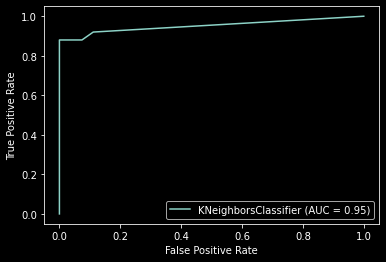

In [17]:
from sklearn.metrics import RocCurveDisplay

roc = RocCurveDisplay.from_estimator(kmeans, X_test, y_test)


- difference to plot with single entries? (size of test set -> only discrete values for single experiments, limited amount of samples)
- summary of curve possible: AUC = area under curve
- TPR and FPR used for ROC only -> similar plots possible with other variables, e.g. precision_recall_curve

# Take-Aways

<p><a href="https://commons.wikimedia.org/wiki/File:Roc-draft-xkcd-style.svg#/media/File:Roc-draft-xkcd-style.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/Roc-draft-xkcd-style.svg/640px-Roc-draft-xkcd-style.svg.png" alt="Roc-draft-xkcd-style.svg"></a><br>By <a href="//commons.wikimedia.org/wiki/User:MartinThoma" title="User:MartinThoma">MartinThoma</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="http://creativecommons.org/publicdomain/zero/1.0/deed.en" title="Creative Commons Zero, Public Domain Dedication">CC0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=70212136">Link</a></p>

- nearest neighbor clustering algorithms are able to offer a probabilistic score for each predicted datum based on the neighborhood chosen 
- the ROC is an envelope that describes how well a classifyer performs given a fixed testset
- ROC expresses the balance between true-positives and false positives


# Further Reading

- some parts of this material were inspired by [Sebastian Raschka](https://sebastianraschka.com)
  + [lecture 12.4, Receiver Operating Curve](https://youtu.be/GdSEkiArM3k)
  
- a generally good resource 
  + [Confusion_matrix](https://en.wikipedia.org/wiki/Confusion_matrix)
  
- all of the above is nicely implemented and documented 
  + [sklearn examples](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py)
  + [roc_curve API docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve)

- [extensive discussion of ROC](https://stackabuse.com/understanding-roc-curves-with-python/)
  